# RNN (Recurrent neural network) : 
### is good for sequenced (Text, Time Series) problem
<img src="../../img/RNN-vs-LSTM-vs-GRU-1200x361.png">
<img src="../../img/1 d_POV7c8fzHbKuTgJzCxtA.gif">
<img src="../../img/rnn_rel.jpeg">



In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as PLT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout,LSTM,GRU,BatchNormalization,Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Simple RNN

In [ ]:
t = np.arange(0,2000)
x = np.sin( .01* t)
X_train,X_test= x[:1500],x[1500:]

In [ ]:
XTrain,YTrain = [],[]
XTest,YTest = [],[]
seq = 5

for start in range(len(X_train)- seq):
    end = start + seq
    XTrain.append(X_train[start:end,])
    YTrain.append(X_train[end])
    
for start in range(len(X_test)- seq):
    end = start + seq
    XTest.append(X_test[start:end,])
    YTest.append(X_test[end])
    
X_train, X_test, Y_train, Y_test = np.array(XTrain), np.array(XTest), np.array(YTrain), np.array(YTest)
X_train = np.reshape( X_train,(X_train.shape[0],X_train.shape[1],1) )
X_test = np.reshape( X_test,(X_test.shape[0],X_test.shape[1],1) )

In [ ]:
PLT.plot(x)

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=64, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
history = model.fit(X_train,Y_train, epochs=100,batch_size=20)

In [ ]:
model.evaluate(X_test,Y_test) # return mean absolute error

In [ ]:
X_train_predicted = model.predict(X_train)
X_test_predicted = model.predict(X_test)
X_final = np.concatenate([X_train_predicted,X_test_predicted],axis=0)

In [ ]:
PLT.plot(x, c='blue')
PLT.plot(X_final, c='red')

# Simple RNN predict Foolad

In [ ]:
DF = pd.read_csv('../../../datasets/foolad.csv')
DF = DF.sort_values(by='<DTYYYYMMDD>').reset_index(drop=True)
DF['<DTYYYYMMDD>'] = DF['<DTYYYYMMDD>'].apply(lambda date: ''.join([ f'{v}-' if i in [3,5] else v for (i,v) in enumerate(str(date)) ]))
DF['<DTYYYYMMDD>'] = pd.to_datetime(DF['<DTYYYYMMDD>'])
DF.rename(columns={
    '<DTYYYYMMDD>' : 'Date',
    '<FIRST>':'Open',
    '<HIGH>':'High',
    '<LOW>':'Low',
    '<CLOSE>':'Close',
    '<VALUE>':'Volume',
},inplace=True)
DF.set_index('Date',inplace=True)
DF = DF[['Open','High','Low','Close','Volume']]
DF.head()

In [ ]:
DF.describe()

In [ ]:
DF.info()

In [ ]:
PLT.figure(figsize=(15,5))
PLT.plot(DF['Close'])

In [ ]:
data = DF['Close'].values
X_train,X_test = data[:2500],data[2500:]

In [ ]:
XTrain,YTrain = [],[]
XTest,YTest = [],[]
seq = 30

for start in range(len(X_train)- seq):
    end = start + seq
    XTrain.append(X_train[start:end,])
    YTrain.append(X_train[end])
    
for start in range(len(X_test)- seq):
    end = start + seq
    XTest.append(X_test[start:end,])
    YTest.append(X_test[end])
    
X_train, X_test, Y_train, Y_test = np.array(XTrain), np.array(XTest), np.array(YTrain), np.array(YTest)
X_train = np.reshape( X_train,(X_train.shape[0],X_train.shape[1],1) )
X_test = np.reshape( X_test,(X_test.shape[0],X_test.shape[1],1) )

In [ ]:
model = Sequential()
model.add(GRU(units=64, activation='relu')) # tanh
model.add(Dense(100))
model.add(Dropout(.5))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
history = model.fit(X_train,Y_train, epochs=50,batch_size=50)

In [ ]:
model.evaluate(X_test,Y_test) # return mean absolute error

In [ ]:
X_train_predicted = model.predict(X_train)
X_test_predicted = model.predict(X_test)
X_final = np.concatenate([X_train_predicted,X_test_predicted],axis=0)

In [ ]:
PLT.figure(figsize=(15,5))

PLT.plot(data, c='blue')
PLT.plot(X_final, c='red')

# Currency Prediction

In [4]:
from collections import deque
from sklearn import preprocessing
import datetime as dt
import pandas_datareader as web 
import requests

In [ ]:
FOOLAD = DF.copy()

In [7]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry


session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)


In [ ]:
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
DOGE = web.DataReader('DOGE-USD', 'yahoo', start, end)


# DOGE = DOGE.reset_index()
# DOGE['Date'] = pd.to_datetime(DOGE['Date'])
# DOGE = DOGE.rename(columns={'Date':'Date'})
# DOGE.drop(columns=['Adj Close'],inplace=True)
# DOGE.set_index('Date',inplace=True)

In [ ]:
# FOOLAD.fillna(method='ffill')

In [ ]:
DF = DOGE.copy()

In [ ]:
DF['future'] = DF['Close'].shift(-3)

In [ ]:
DF.head()

In [ ]:
def compare(future,current):
    return 1 if future > current else 0
DF['target'] = list(map(compare, DF['future'], DF['Close']))

In [ ]:
DF.head()

In [ ]:
def preprocess_currency(DF,COLS,seq):
    DF = DF.copy()
    for c in COLS:
        DF[c] = DF[c].pct_change()
        DF.dropna(inplace=True)
        DF[c] = preprocessing.scale(DF[c])
    DF.dropna(inplace=True)
    sequences = []
    prev_days = deque(maxlen=seq)
    for i in DF.values:
        prev_days.append(i[:-2])
        if len(prev_days) == seq:
            sequences.append([np.array(prev_days),i[-1]])
#     print(sequences)        
    random.shuffle(sequences)
    buys = []
    sells= []
    for sequence, target in sequences:
        if target == 0:
            sells.append([sequence,target])
        else :
            buys.append([sequence,target])
    random.shuffle(buys)
    random.shuffle(sells)
    
    lower = min(len(buys), len(sells))
    buys = buys[:lower]
    sells = sells[:lower]
    sequences = buys+sells
    random.shuffle(sequences)
    X = []
    Y = []
    for seq, target in sequences:
        X.append(seq)
        Y.append(target)
    return np.array(X), np.array(Y)

In [ ]:
DF_train, DF_test = train_test_split(DF,test_size=.4,shuffle=False)

In [ ]:
seq = 90
X_COLS = DF.columns.difference(['future','target'])
                               
X_train, Y_train = preprocess_currency(DF_train,X_COLS,seq)
X_test, Y_test = preprocess_currency(DF_test,X_COLS,seq)
# X_train.shape

In [ ]:
model = Sequential()
model.add( 
    LSTM(units=32,
         input_shape=(X_train.shape[1:]),
         activation='relu',
#          return_sequences=True
        ) 
) 
# model.add(BatchNormalization())
# model.add(GRU(units=12,activation='relu',)) 
model.add(Dense(10))
# model.add(Dropout(.5))
# model.add(Dense(10))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train, epochs=100,batch_size=50, validation_data=(X_test,Y_test) )

In [ ]:
Y_predicted = model.predict(X_test)
Y_predicted = [np.argmax(x) for x in Y_predicted]
# Y_predicted = [1 if x[1]>.4 else 0 for x in Y_predicted]

print(metrics.classification_report(Y_test,Y_predicted))
print(metrics.confusion_matrix(Y_test,Y_predicted))

In [ ]:
today = DF.iloc[len(DF)-15:,:-2]

In [ ]:
today

In [ ]:
np.argmax(model.predict(
 [today.values]
))

# LSTM Currency Prediction

In [35]:
DF = pd.read_csv('../../../datasets/DOGE-USD(6).csv')
DF['Date'] = pd.to_datetime(DF['Date'])
DF.set_index('Date',inplace=True)
DF.dropna(inplace=True)
DF.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


In [36]:
DF_train, DF_test = train_test_split(DF,test_size=.3,shuffle=False)

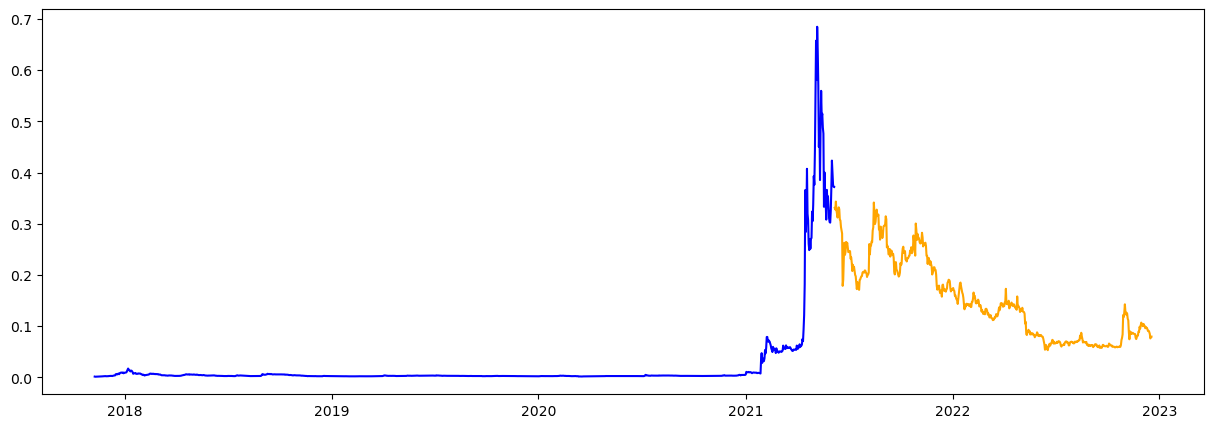

In [37]:
PLT.figure(figsize=(15,5))
PLT.plot(DF_train['Close'], c='blue',label='train_data')
PLT.plot(DF_test['Close'], c='orange',label='test_data')


In [38]:
def extract_window_data(DF,window):
    window_data = []
    for i in range(len(DF)- window):
        tmp = DF[i:(i+window)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [39]:
def prepare_data(DF,TARGET_COL,window):
    DF_train, DF_test = train_test_split(DF,test_size=.1,shuffle=False)
    
    X_train = extract_window_data(
        DF_train[DF_train.columns.difference([TARGET_COL])],
        window
    )
    
    X_test = extract_window_data(
        DF_test[DF_test.columns.difference([TARGET_COL])],
        window
    )
    
    Y_train = DF_train[TARGET_COL][window:].values
    Y_test = DF_test[TARGET_COL][window:].values
    
    Y_train = DF_train[TARGET_COL][:-window].values 
    Y_test = DF_test[TARGET_COL][:-window].values 
    
    return DF_train, DF_test, X_train, X_test, Y_train, Y_test

In [124]:
DF2 = DF.iloc[1:].reset_index(drop=True) / DF.iloc[:-1].reset_index(drop=True)

In [125]:
window = 10
DF_train, DF_test, X_train, X_test, Y_train, Y_test = prepare_data(DF2,'Close',window)

Y_train[Y_train>1] = 1
Y_train[Y_train< 1] = 0
Y_test[Y_test>1] = 1
Y_test[Y_test< 1] = 0

In [149]:
model = Sequential()
model.add( 
    LSTM(units=32,
         input_shape=(X_train.shape[1:]),
         activation='relu',
#          return_sequences=True
        ) 
) 
model.add(Dropout(.5))
# model.add(Dense(10))
# model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [151]:
history = model.fit(X_train,Y_train, epochs=300,batch_size=50, validation_data=(X_test,Y_test), shuffle=True )

Epoch 1/300
34/34 [==============================] - 0s 14ms/step - loss: 0.3161 - accuracy: 0.8543 - val_loss: 0.2317 - val_accuracy: 0.9209
Epoch 2/300
34/34 [==============================] - 0s 9ms/step - loss: 0.3214 - accuracy: 0.8567 - val_loss: 0.2377 - val_accuracy: 0.9096
Epoch 3/300
34/34 [==============================] - 0s 9ms/step - loss: 0.2536 - accuracy: 0.8987 - val_loss: 0.2658 - val_accuracy: 0.8983
Epoch 4/300
34/34 [==============================] - 0s 9ms/step - loss: 0.2395 - accuracy: 0.9011 - val_loss: 0.3125 - val_accuracy: 0.8644
Epoch 5/300
34/34 [==============================] - 0s 9ms/step - loss: 0.2579 - accuracy: 0.8837 - val_loss: 0.2024 - val_accuracy: 0.9040
Epoch 6/300
34/34 [==============================] - 0s 9ms/step - loss: 0.2254 - accuracy: 0.9095 - val_loss: 0.2642 - val_accuracy: 0.8983
Epoch 7/300
34/34 [==============================] - 0s 9ms/step - loss: 0.2970 - accuracy: 0.8681 - val_loss: 0.2316 - val_accuracy: 0.8814
Epoch 8/300


34/34 [==============================] - 0s 10ms/step - loss: 0.1891 - accuracy: 0.9197 - val_loss: 0.1613 - val_accuracy: 0.9209
Epoch 59/300
34/34 [==============================] - 0s 11ms/step - loss: 0.2250 - accuracy: 0.9023 - val_loss: 0.1720 - val_accuracy: 0.9266
Epoch 60/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1965 - accuracy: 0.9173 - val_loss: 0.1618 - val_accuracy: 0.9322
Epoch 61/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1960 - accuracy: 0.9107 - val_loss: 0.1726 - val_accuracy: 0.9209
Epoch 62/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1974 - accuracy: 0.9197 - val_loss: 0.2180 - val_accuracy: 0.8870
Epoch 63/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1930 - accuracy: 0.9143 - val_loss: 0.2598 - val_accuracy: 0.8927
Epoch 64/300
34/34 [==============================] - 0s 12ms/step - loss: 0.2128 - accuracy: 0.8969 - val_loss: 0.2535 - val_accuracy: 0.8983
Epoch 65/300

34/34 [==============================] - 0s 10ms/step - loss: 0.1997 - accuracy: 0.9029 - val_loss: 0.1671 - val_accuracy: 0.9322
Epoch 116/300
34/34 [==============================] - 0s 10ms/step - loss: 0.2190 - accuracy: 0.8969 - val_loss: 0.1840 - val_accuracy: 0.9040
Epoch 117/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1945 - accuracy: 0.9149 - val_loss: 0.5534 - val_accuracy: 0.8079
Epoch 118/300
34/34 [==============================] - 0s 10ms/step - loss: 0.2841 - accuracy: 0.8687 - val_loss: 0.1969 - val_accuracy: 0.9379
Epoch 119/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1706 - accuracy: 0.9376 - val_loss: 0.1899 - val_accuracy: 0.9040
Epoch 120/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.9418 - val_loss: 0.4091 - val_accuracy: 0.8588
Epoch 121/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1696 - accuracy: 0.9215 - val_loss: 0.1452 - val_accuracy: 0.9492
Epoch 

Epoch 172/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1458 - accuracy: 0.9508 - val_loss: 0.1445 - val_accuracy: 0.9266
Epoch 173/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1400 - accuracy: 0.9394 - val_loss: 0.1317 - val_accuracy: 0.9548
Epoch 174/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1408 - accuracy: 0.9382 - val_loss: 0.1550 - val_accuracy: 0.9153
Epoch 175/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1461 - accuracy: 0.9347 - val_loss: 0.1239 - val_accuracy: 0.9492
Epoch 176/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1695 - accuracy: 0.9275 - val_loss: 0.7012 - val_accuracy: 0.7853
Epoch 177/300
34/34 [==============================] - 0s 10ms/step - loss: 0.4229 - accuracy: 0.8831 - val_loss: 0.2328 - val_accuracy: 0.9096
Epoch 178/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1769 - accuracy: 0.9388 - val_loss: 0.1806 - val_accuracy:

Epoch 229/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1146 - accuracy: 0.9448 - val_loss: 0.2340 - val_accuracy: 0.8814
Epoch 230/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1668 - accuracy: 0.9311 - val_loss: 0.1221 - val_accuracy: 0.9492
Epoch 231/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1933 - accuracy: 0.9245 - val_loss: 0.2555 - val_accuracy: 0.8983
Epoch 232/300
34/34 [==============================] - 0s 11ms/step - loss: 0.4119 - accuracy: 0.8321 - val_loss: 0.3204 - val_accuracy: 0.8701
Epoch 233/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1917 - accuracy: 0.9263 - val_loss: 0.1550 - val_accuracy: 0.9435
Epoch 234/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1396 - accuracy: 0.9574 - val_loss: 0.1209 - val_accuracy: 0.9605
Epoch 235/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1160 - accuracy: 0.9610 - val_loss: 0.1083 - val_accuracy:

Epoch 286/300
34/34 [==============================] - 0s 14ms/step - loss: 0.0896 - accuracy: 0.9628 - val_loss: 0.1007 - val_accuracy: 0.9492
Epoch 287/300
34/34 [==============================] - 0s 11ms/step - loss: 0.0961 - accuracy: 0.9562 - val_loss: 0.1408 - val_accuracy: 0.9435
Epoch 288/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1701 - accuracy: 0.9424 - val_loss: 0.1013 - val_accuracy: 0.9605
Epoch 289/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.9550 - val_loss: 0.0877 - val_accuracy: 0.9774
Epoch 290/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1591 - accuracy: 0.9269 - val_loss: 0.1028 - val_accuracy: 0.9605
Epoch 291/300
34/34 [==============================] - 0s 11ms/step - loss: 0.1043 - accuracy: 0.9568 - val_loss: 0.1026 - val_accuracy: 0.9548
Epoch 292/300
34/34 [==============================] - 0s 10ms/step - loss: 0.1193 - accuracy: 0.9508 - val_loss: 0.2656 - val_accuracy:

In [152]:
Y_predict = model.predict(X_test)
Y_predict[Y_predict > 0.5] = 1
Y_predict[Y_predict <= 0.5] = 0
# Y_predict = [np.argmax(x) for x in Y_predict]
print(metrics.classification_report(Y_test,Y_predict))

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95        88
         1.0       0.99      0.90      0.94        89

    accuracy                           0.94       177
   macro avg       0.95      0.94      0.94       177
weighted avg       0.95      0.94      0.94       177



In [133]:
model = Sequential()
model.add( 
    LSTM(units=32,
         input_shape=(X_train.shape[1:]),
         activation='relu',
#          return_sequences=True
        ) 
) 
# model.add(Dropout(.5))
# model.add(Dense(10))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='mse',optimizer='Adam',metrics=['accuracy'])

In [134]:
history = model.fit(X_train,Y_train, epochs=100,batch_size=50, validation_data=(X_test,Y_test), shuffle=True )

Epoch 1/100
34/34 [==============================] - 3s 17ms/step - loss: 0.3222 - accuracy: 0.5054 - val_loss: 0.2518 - val_accuracy: 0.4689
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 0.2530 - accuracy: 0.5132 - val_loss: 0.2516 - val_accuracy: 0.4915
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 0.2498 - accuracy: 0.5348 - val_loss: 0.2499 - val_accuracy: 0.4746
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 0.2494 - accuracy: 0.5090 - val_loss: 0.2494 - val_accuracy: 0.4972
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 0.2470 - accuracy: 0.5354 - val_loss: 0.2473 - val_accuracy: 0.5932
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 0.2473 - accuracy: 0.5222 - val_loss: 0.2469 - val_accuracy: 0.5198
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 0.2437 - accuracy: 0.5600 - val_loss: 0.2430 - val_accuracy: 0.5480
Epoch 8/100


34/34 [==============================] - 0s 9ms/step - loss: 0.1121 - accuracy: 0.8417 - val_loss: 0.0947 - val_accuracy: 0.8644
Epoch 59/100
34/34 [==============================] - 0s 12ms/step - loss: 0.1021 - accuracy: 0.8717 - val_loss: 0.0968 - val_accuracy: 0.8588
Epoch 60/100
34/34 [==============================] - 0s 10ms/step - loss: 0.1024 - accuracy: 0.8591 - val_loss: 0.1052 - val_accuracy: 0.8362
Epoch 61/100
34/34 [==============================] - 0s 10ms/step - loss: 0.1238 - accuracy: 0.8231 - val_loss: 0.0983 - val_accuracy: 0.8588
Epoch 62/100
34/34 [==============================] - 0s 9ms/step - loss: 0.1154 - accuracy: 0.8351 - val_loss: 0.1403 - val_accuracy: 0.7627
Epoch 63/100
34/34 [==============================] - 0s 10ms/step - loss: 0.1158 - accuracy: 0.8369 - val_loss: 0.0991 - val_accuracy: 0.8588
Epoch 64/100
34/34 [==============================] - 0s 9ms/step - loss: 0.1049 - accuracy: 0.8555 - val_loss: 0.0929 - val_accuracy: 0.8644
Epoch 65/100
34

In [143]:
Y_predict = model.predict(X_test)
# Y_predict[Y_predict > 0.5] = 1
# Y_predict[Y_predict <= 0.5] = 0
# Y_predict = [np.argmax(x) for x in Y_predict]
metrics.r2_score(y_pred=Y_predict,y_true=Y_test )

6/6 [==============================] - 0s 4ms/step


0.6623234641536087